<br><font face="Times New Roman" size=5><div dir=ltr align=center>
<font color=blue size=8>
    Introduction to Machine Learning <br>
<font color=red size=5>
    Sharif University of Technology - Computer Engineering Department <br>
    Fall 2022<br> <br>
<font color=black size=6>
    Homework 2: Practical - SVM
    <br>
<font color=black size=4>
    Alireza Gargoori Motlagh, Alireza Heidari
    
<br><br>
<font size=4>
   **Name**: <br>
   **Student ID**: <br> <br>
In this homework, we are going to implement the algorithms from the second and third chapters of the course, so reading the notebooks of these chapters would be quite useful. Also, we are going to evaulate and compare our models by the metrics defined in chapter 3. Keep in mind to complete all of the following questions and write your own codes in the TODO parts.

## <font face="Times New Roman" size=4><div dir=ltr>
## Problem 3: Face Classification by SVM on Eigenfaces (150 points)
In the following problem, we are going to build a classifier to distinguish the faces of 40 people on a toy dataset. The dataset includes 400 pictures of 40 people faces, each by a 64*64 pixel picture. Use the following cell to download the dataset:

In [1]:
from sklearn import datasets

import numpy as np
import matplotlib.pyplot as plt

faces = datasets.fetch_olivetti_faces()
n_samples, h, w = faces.images.shape
print(faces.data.shape)
print(faces.images[0].shape)


(400, 4096)
(64, 64)


In [2]:
# print(faces.target.shape)

<font face="Times New Roman" size=4><div dir=ltr>
### Visualization of the Faces (5 points)
Plot an image of each class in one figure using subplots. (Note that the design matrix X is availabe in <code>faces.data</code> and the target values available in <code>faces.target</code> .)

399


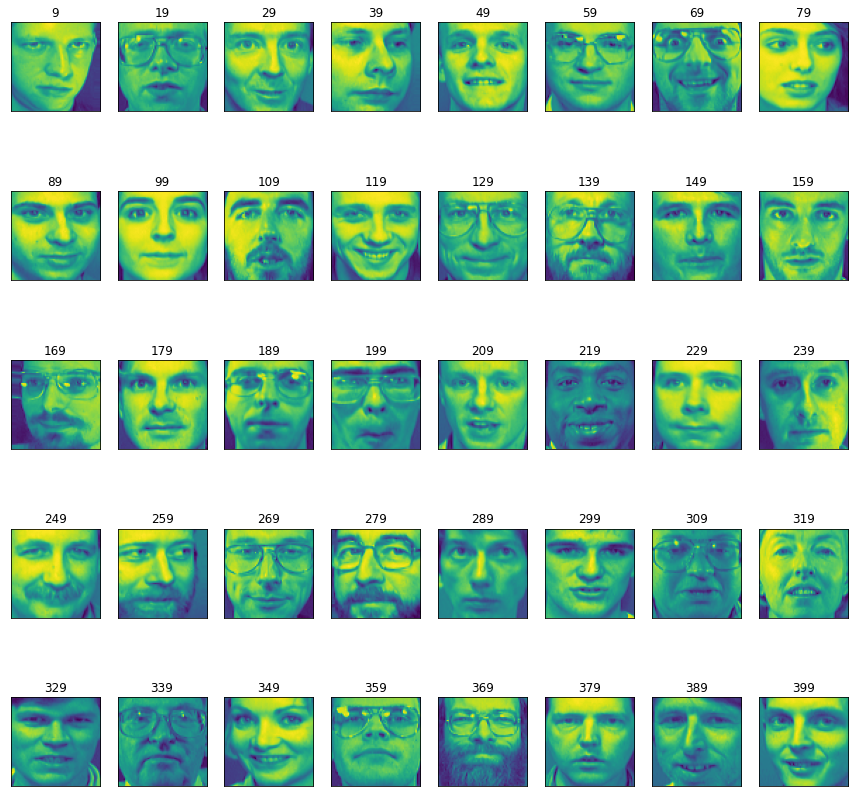

In [3]:
fig, ax = plt.subplots(5, 8, figsize=(15, 15))
face_index = -1
for i in range(5):
    for j in range(8):
        face_index += 10
        face = faces.images[face_index]
        ax[i, j].imshow(face)
        ax[i, j].set_title(f'{face_index}')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        
print(face_index)


<font face="Times New Roman" size=4><div dir=ltr>
### Train-Test Split (2 points)
Split the data into train and test sets and print the dimensions of each set. (70% for train and 30% for test)

In [4]:
#TODO
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(faces.data, faces.target, test_size=0.30, random_state=42)

<font face="Times New Roman" size=4><div dir=ltr>
### Dimensionality Reduction (18 points)
As you might have guessed, the number of featuers, i.e. pixels, is quite large and training a classifier might take a considerbale time. However, using a wise method to reduce the dimension of our data could decrease the cost of training the model. In the following cell use PCA (Principal Component Analysis) to reduce the dimension of the dataset. Choose an appropirate number of components in your PCA and explain your reason for your choice.

In [5]:
#To choose an appropriate number of components we can come up with a threshold to determine
# what fraction of training set's variance should be kept. For example here I decide to
# choose this threshold to be equal to 95%.
# To implement this idea I use numpy.cumsum which returns the the cumulative sum of 
# the elements along a given axis.
from sklearn.decomposition import PCA
print(x_train.shape)
pca = PCA()
pca.fit(x_train)
best_dimension = np.argmax(np.cumsum(pca.explained_variance_ratio_)>=0.95) + 1
print(f'Proper dimension of transformed data is {best_dimension}.')

(280, 4096)
Proper dimension of transformed data is 106.


<font face="Times New Roman" size=4><div dir=ltr>
Plot the scree plot of the proportion of the variance explained(PVE) vs principal components to determine the number of principal components for futher analysis.

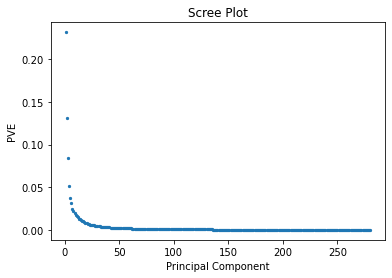

In [6]:
pca = PCA()
pca.fit(x_train)

PVE_list = pca.explained_variance_ratio_
principal_comp_list = np.array([i+1 for i in range(len(PVE_list))])

plt.scatter(principal_comp_list, PVE_list, s=5)
plt.xlabel('Principal Component')
plt.ylabel('PVE')
plt.title('Scree Plot')
plt.show()

<font face="Times New Roman" size=4><div dir=ltr>
### Eigenfaces: Principal Components Visualization (25 points)
Plot the mean face using your PCA model with <code>pca.mean_</code> attribute followed by a reshape to original dimensions. What is this mean vector?

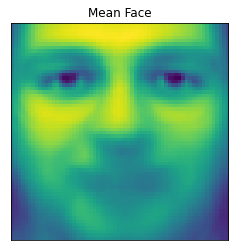

In [7]:
# This mean vector is empirical mean, estrimated from the training set.
pca = PCA(n_components=best_dimension)
pca.fit(x_train)
mean_face = pca.mean_
mean_face = np.reshape(mean_face, (h, w))
plt.imshow(mean_face)
plt.title('Mean Face')
plt.xticks([])
plt.yticks([])
plt.show()

<font face="Times New Roman" size=4><div dir=ltr>
Eigenfaces is the name given to a set of eigenvectors when used in the computer vision problem of human face recognition. Plot the 30 first eigenfaces sorted by their rank from the most important to the lowest. Can you explain what these faces indicate?

'\nThese eigne faces construct a basis for the vector space of covariance matrix.\n'

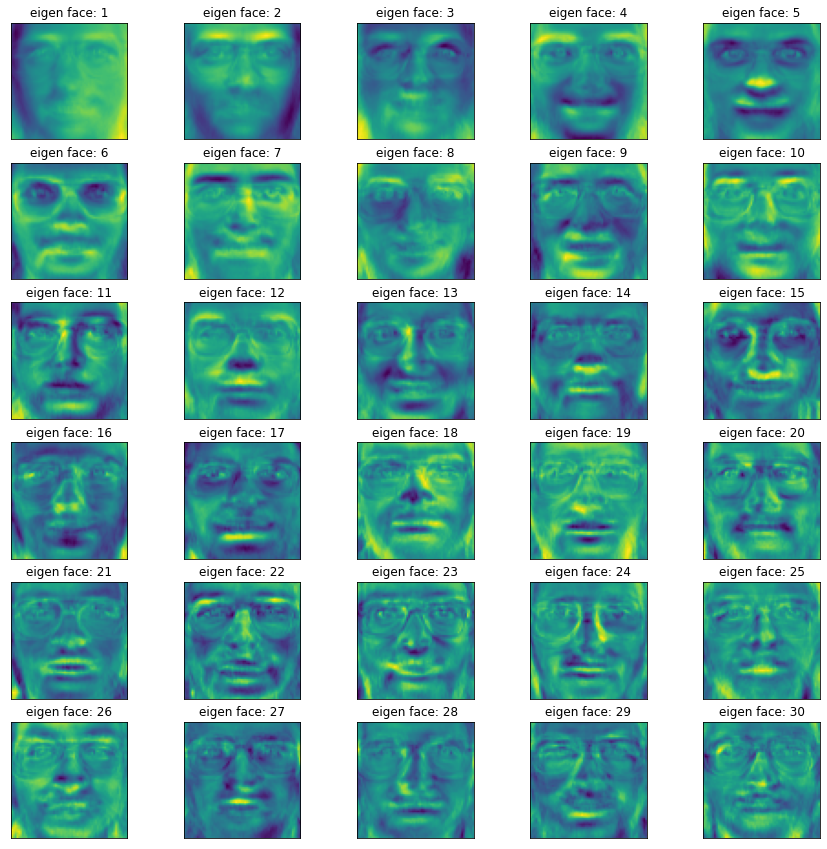

In [8]:
eigen_faces = pca.components_.reshape(best_dimension, h, w)
fig_, ax_ = plt.subplots(6, 5, figsize=(15, 15))

counter = 0
for i in range(6):
    for j in range(5):
        counter += 1
        eigen_face = eigen_faces[counter]
        ax_[i, j].imshow(eigen_face)
        ax_[i, j].set_title(f'eigen face: {counter}')
        ax_[i, j].set_xticks([])
        ax_[i, j].set_yticks([])
        pass

"""
These eigne faces construct a basis for the vector space of covariance matrix.
"""

<font face="Times New Roman" size=4><div dir=ltr>
Transform your train and test sets to the new feature space using your PCA module. 

In [9]:
pca_ = PCA(n_components=best_dimension)
pca_.fit(x_train)
x_train_reduced = pca_.transform(x_train)
x_test_reduced = pca_.transform(x_test)

<font face="Times New Roman" size=4><div dir=ltr>
### Training your SVM Classifier (50 points)
Train an SVM classifier on the transformed dataset in the new feature space. You should use Grid Search Cross Validation or other validation techniques to obtain the best hyperparameters for your classifier. 

In [10]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

C = np.logspace(-5, 3, 9)
gamma = np.logspace(-3, 5, 9)
degree = np.arange(1, 5)
kernel = ['rbf', 'poly']
param_grid = dict(gamma=gamma, C=C, degree=degree, kernel=kernel)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid)
grid.fit(x_train_reduced, y_train)
best_params = grid.best_params_
print("Best Parameters: ", best_params)
clf = svm.SVC(kernel=best_params['kernel'], C=best_params['C'], degree=best_params['degree'], gamma=best_params['gamma'])
clf.fit(x_train_reduced, y_train)

c:\Users\mohammad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters:  {'C': 1e-05, 'degree': 1, 'gamma': 10000.0, 'kernel': 'poly'}


SVC(C=1e-05, degree=1, gamma=10000.0, kernel='poly')

<font face="Times New Roman" size=4><div dir=ltr>
After training your model, we can check its prediction on test samples. Run the following cell to check your model predictions with the target values on test samples. Predictions with red label indicate false classification of your model.

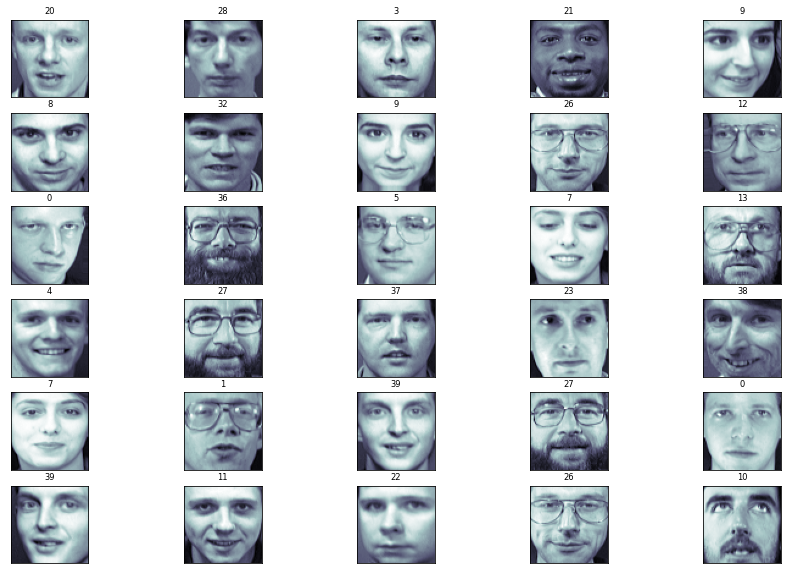

In [11]:
fig = plt.figure(figsize=(15, 10))
for i in range(30):
    ax = fig.add_subplot(6, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(x_test[i].reshape(faces.images[0].shape),
              cmap=plt.cm.bone)
    y_pred = clf.predict(x_test_reduced[i, np.newaxis])[0] #X_test_new is the transformed X_test after PCA.
    color = ('black' if y_pred == y_test[i] else 'red')
    ax.set_title(y_pred, fontsize='small', color=color)

<font face="Times New Roman" size=4><div dir=ltr>
## Performance Measures
Let's evaluate your classifier to find out how good your model is.
    
    
### Precision Recall Tradeoff (20 points)
Plot the precision and recall versus the decision threshold figure and precision vs recall figure.

(120, 40)
(120, 40)
Value of decision threshold:  38.32627598467561


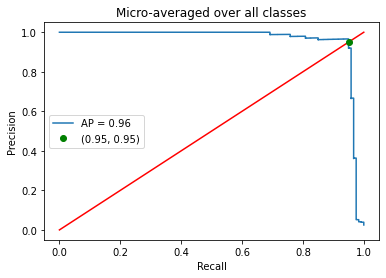

In [12]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay

num_classes = 40
y_test_labels = label_binarize(y_test, classes=[i for i in range(num_classes)])
 

svm_train_scores = clf.decision_function(x_test_reduced)
y_pred_svm = clf.predict(x_test_reduced)
y_pred_svm_labels = label_binarize(y_pred_svm, classes=[i for i  in range(num_classes)])
print(svm_train_scores.shape)
print(y_test_labels.shape)



precisions, recalls, _ = precision_recall_curve(y_test_labels.ravel(), svm_train_scores.ravel())

avg_precisions = average_precision_score(y_test_labels, svm_train_scores, average="micro")



display = PrecisionRecallDisplay(recall=recalls, precision=precisions, average_precision=avg_precisions)
display.plot()
plt.plot(recalls, recalls, 'r')
equal_recall_percision_index = np.argwhere(np.abs(recalls-precisions)==0)
label = f'({recalls[equal_recall_percision_index][0][0]}, {precisions[equal_recall_percision_index][0][0]})'
plt.plot(recalls[equal_recall_percision_index], precisions[equal_recall_percision_index], 'go', label=label)
print("Value of decision threshold: ", _[equal_recall_percision_index][0][0])
display.ax_.set_title("Micro-averaged over all classes")
plt.legend()

<font face="Times New Roman" size=4><div dir=ltr>
Then find the decision threshold, where the recall is equal to the precision. Write down it in the below cell:
    <br>
note: it should be apparent in the above figures.

decision_threshold = 38.33

recall at the above threshold = 0.95

<font face="Times New Roman" size=4><div dir=ltr>
### ROC/AUC (10 points)
Train a RandomForestClassifier with 30 estimators then plot a ROC curve, and calculate AUC for both randomForsetClassifier and your SVM classifier that you trained earlier, which one is the best by considering AUC indicator?


c:\Users\mohammad\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\mohammad\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


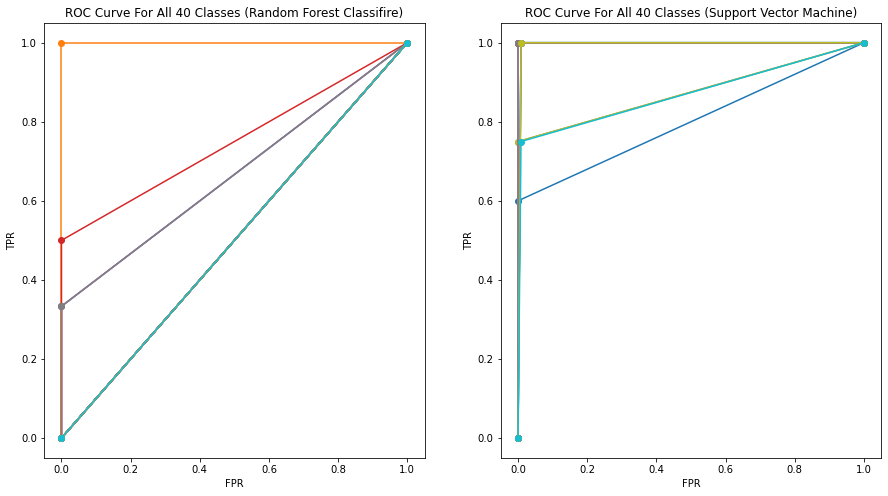

AUC score for each class (RFC):  [0.5        0.5        0.5        0.5        0.66666667 0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.66666667 0.5               nan 0.5
 0.5        0.5        0.5        1.         0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.75       0.5        0.5
 0.5        0.66666667 0.5        0.5       ]
AUC score for each class (SVM):  [0.8        1.         1.         1.         1.         1.
 1.         0.875      1.         0.9957265  1.         1.
 1.         1.         1.         1.                nan 0.9957265
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.875      0.9957265
 1.         1.         1.         1.         0.99576271 1.
 1.         1.         0.99557522 0.87068966]


'\nAs it is obvious in the figure we have a better performance of metrics in the case of \nSVM than RFC.\n'

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

num_classes = 40
rfc = RandomForestClassifier(n_estimators=30)
y_train_labels = label_binarize(y_train, classes=[i for i in range(num_classes)])
y_test_labels = label_binarize(y_test, classes=[i for i in range(num_classes)])
rfc.fit(x_train_reduced, y_train_labels)
y_pred_rfc = rfc.predict(x_test_reduced)
auc_arr_rfc = np.zeros(num_classes)
auc_arr_svm = np.zeros(num_classes)
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
for i in range(num_classes):
    fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_test_labels[:, i], y_pred_rfc[:, i])
    fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test_labels[:, i], y_pred_svm_labels[:, i])
    auc_arr_rfc[i] = auc(fpr_rfc, tpr_rfc)
    auc_arr_svm[i] = auc(fpr_svm, tpr_svm)
    ax[0].plot(fpr_rfc, tpr_rfc, '-o')
    ax[1].plot(fpr_svm, tpr_svm, '-o')

ax[0].set_xlabel('FPR')
ax[0].set_ylabel('TPR')
ax[0].set_title('ROC Curve For All 40 Classes (Random Forest Classifire)')
ax[1].set_xlabel('FPR')
ax[1].set_ylabel('TPR')
ax[1].set_title('ROC Curve For All 40 Classes (Support Vector Machine)')
plt.show()
print("AUC score for each class (RFC): ", auc_arr_rfc)
print("AUC score for each class (SVM): ", auc_arr_svm)
"""
As it is obvious in the figure we have a better performance of metrics in the case of 
SVM than RFC.
"""

<font face="Times New Roman" size=4><div dir=ltr>
### Classification Report (5 points)
Use the <code>classification_report</code> to describe the performance of your SVM model with different metrics. Explain your results and compare the predictions of model on different classes in few sentences.

In [23]:
from sklearn.metrics import classification_report

y_pred_svm_labels = label_binarize(y_pred_svm, classes=[i for i in range(num_classes)])
report_svm = classification_report(y_test_labels, y_pred_svm_labels)
print(report_svm)


y_pred_rfc_labels = label_binarize(y_pred_rfc, classes=[i for i in range(num_classes)])
report_rfc = classification_report(y_test_labels, y_pred_rfc_labels)
print(report_rfc)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         4
           4       1.00      0.33      0.50         3
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         3
          14       1.00      0.33      0.50         3
          15       0.00      0.00      0.00         3
          16       0.00      0.00      0.00         0
          17       0.00    

c:\Users\mohammad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mohammad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mohammad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<font face="Times New Roman" size=4><div dir=ltr>
### Confusion Matrix (15 points)
Plot the confusion matrix of the classifier's predictions.
Let’s focus on the errors of the plot. Divide each value in the confusion matrix by the number of images in the corresponding class so that you can compare error rates instead of absolute number of errors, then plot the result.

In [85]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

confusion_matrix_svm = confusion_matrix(y_test, y_pred_svm, labels=[i for i in range(num_classes)]) 
print(confusion_matrix_svm)

[[3 0 0 ... 0 0 1]
 [0 4 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 7 0]
 [0 0 0 ... 0 0 3]]


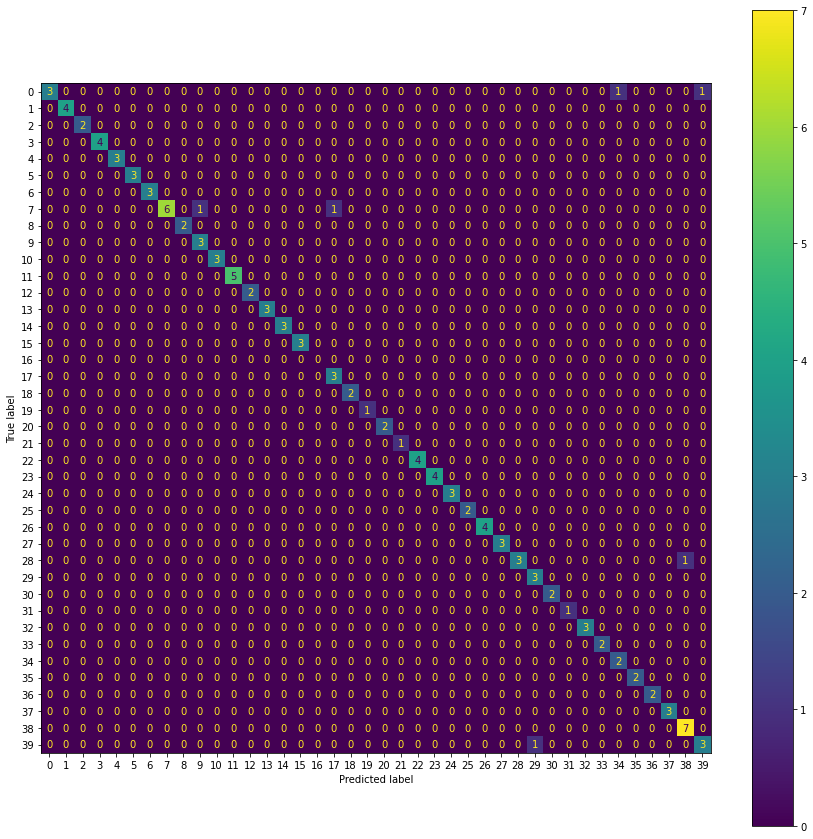

In [86]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_svm)

fig, ax = plt.subplots(figsize=(15, 15))
cm_display.plot(ax=ax)
plt.show()

In [87]:
# TODO: calculate norm_conf_mx then print it

5.0
4.0
2.0
4.0
3.0
3.0
3.0
8.0
2.0
3.0
3.0
5.0
2.0
3.0
3.0
3.0
0.0
3.0
2.0
1.0
2.0
1.0
4.0
4.0
3.0
2.0
4.0
3.0
4.0
3.0
2.0
1.0
3.0
2.0
2.0
2.0
2.0
3.0
7.0
4.0


C:\Users\mohammad\AppData\Local\Temp\ipykernel_12084\1826398713.py:7: RuntimeWarning: invalid value encountered in true_divide
  confusion_matrix_svm_[i, :] = confusion_matrix_svm[i, :]/iterm_in_classes[i]


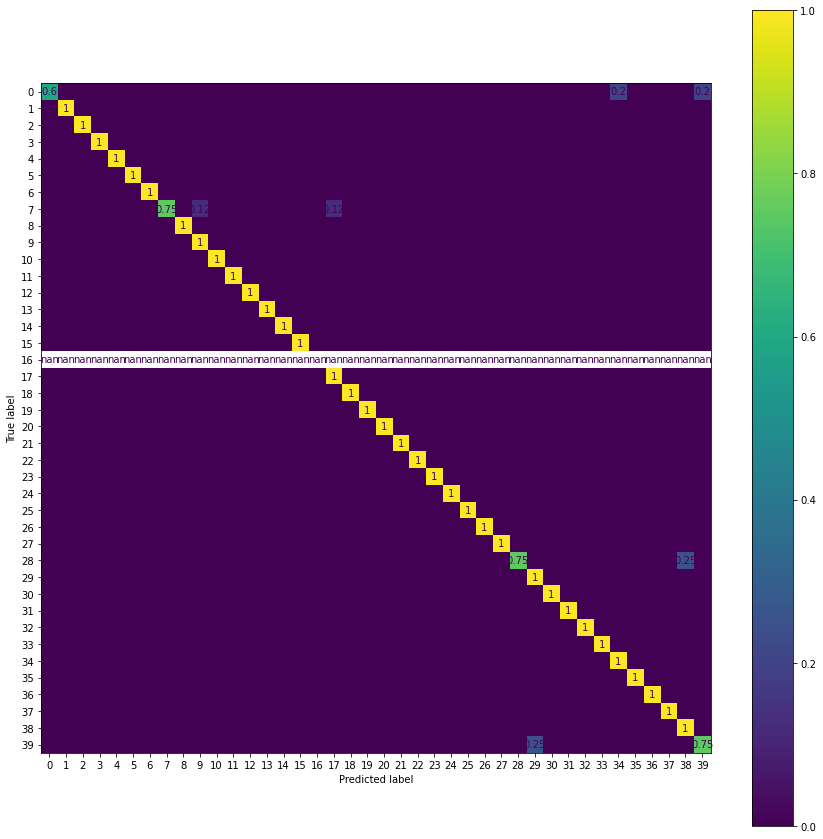

In [89]:
iterm_in_classes = np.zeros(num_classes)
# print(confusion_matrix_svm)
confusion_matrix_svm_ = np.zeros(confusion_matrix_svm.shape)
for i in range(num_classes):
    iterm_in_classes[i] = np.sum(confusion_matrix_svm[i, :])
    print(iterm_in_classes[i])
    if iterm_in_classes[i]!=0:
        confusion_matrix_svm_[i, :] = confusion_matrix_svm[i, :]/iterm_in_classes[i]
    
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_svm_)

fig, ax = plt.subplots(figsize=(15, 15))
cm_display.plot(ax=ax)
plt.show()